In [2]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras_preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

In [3]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'C:\\Users\\HP\\OneDrive\Desktop\\pro_dataset\\training'  
validation_data_dir = 'C:\\Users\\HP\\OneDrive\Desktop\\pro_dataset\\validating'  
test_data_dir = 'C:\\Users\\HP\\OneDrive\Desktop\\pro_dataset\\testing'
   
# number of epochs to train top model  
epochs = 7 #this can been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [4]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)  

In [6]:
start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


Found 731 images belonging to 2 classes.
15/15 [==============================] - 119s 8s/step
Time:  0:02:00.971138


In [7]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1020 images belonging to 2 classes.


C:\Users\HP\AppData\Local\Temp\ipykernel_28440\2496864306.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = vgg16.predict_generator(


Time:  0:02:29.691256


In [8]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 29 images belonging to 2 classes.


C:\Users\HP\AppData\Local\Temp\ipykernel_28440\1258901172.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(


Time:  0:00:05.749020


In [9]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 


Found 731 images belonging to 2 classes.


In [10]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 1020 images belonging to 2 classes.


In [11]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 29 images belonging to 2 classes.


In [12]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

C:\ana\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/7
15/15 [==============================] - 4s 78ms/step - loss: 0.7945 - acc: 0.6662 - val_loss: 0.4021 - val_acc: 0.8000
Epoch 2/7
15/15 [==============================] - 1s 38ms/step - loss: 0.4094 - acc: 0.8222 - val_loss: 0.3635 - val_acc: 0.8265
Epoch 3/7
15/15 [==============================] - 1s 48ms/step - loss: 0.3233 - acc: 0.8632 - val_loss: 0.2641 - val_acc: 0.8951
Epoch 4/7
15/15 [==============================] - 1s 37ms/step - loss: 0.2418 - acc: 0.8974 - val_loss: 0.4184 - val_acc: 0.8304
Epoch 5/7
15/15 [==============================] - 1s 35ms/step - loss: 0.3105 - acc: 0.8919 - val_loss: 0.2537 - val_acc: 0.9098
Epoch 6/7
15/15 [==============================] - 1s 36ms/step - loss: 0.2189 - acc: 0.9166 - val_loss: 0.2240 - val_acc: 0.9147
Epoch 7/7
21/21 [==============================] - 0s 7ms/step - loss: 0.2286 - acc: 0.9127
[INFO] accuracy: 91.27%
[INFO] Loss: 0.2286490947008133
Time:  0:00:08.308888


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2,514,052
Trainable params: 2,514,052
Non-

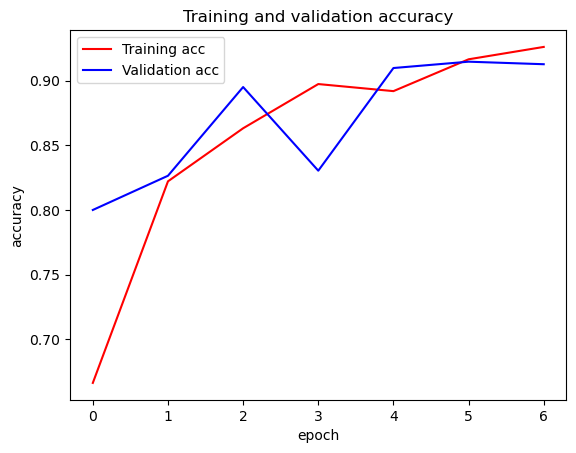

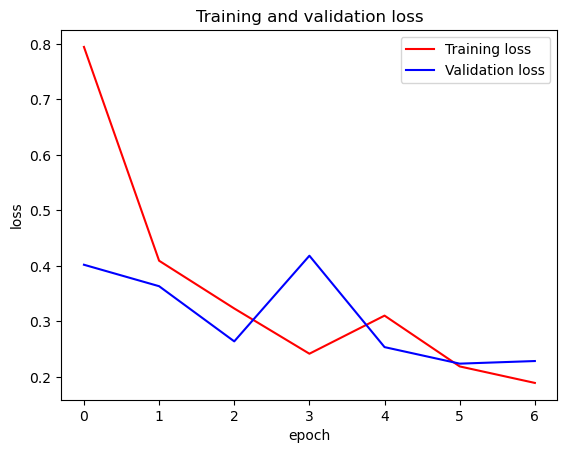

In [14]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [15]:
model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 68ms/step - loss: 0.0536 - acc: 1.0000


[0.05355416610836983, 1.0]

In [16]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.61931896 0.         0.         ... 0.         0.8360786
    0.        ]
   [0.48080292 0.         0.         ... 0.         0.4936508
    0.        ]
   [0.18586707 0.         0.         ... 0.         0.6890369
    0.        ]
   ...
   [0.         0.         0.63667476 ... 0.         0.44588625
    0.        ]
   [0.18402433 0.         0.382191   ... 0.         0.7707309
    0.        ]
   [0.6177041  0.         1.0498042  ... 0.         0.76193434
    0.        ]]

  [[0.16720963 0.         0.6235392  ... 0.         0.73905635
    0.        ]
   [0.         0.         1.7925546  ... 0.         0.29497
    0.55213463]
   [0.         0.         1.5383282  ... 0.         0.46262643
    0.7799077 ]
   ...
   [0.         0.         1.2571623  ... 0.         0.22683436
    0.8514886 ]
   [0.9819035  0.         0.9087245  ... 0.         0.75569093
    0.        ]
   [1.1358807  0.         0.6725799  ... 0.         1.010627
    0.        ]]

  [[0.         0.         0.82977

1/1 [==============================] - 0s 151ms/step
rounded test_labels [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [17]:
Fassion = ['healthy', 'lumpy']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=Fassion )
print(classification_metrics)

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00        16
       lumpy       1.00      1.00      1.00        13

   micro avg       1.00      1.00      1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29
 samples avg       1.00      1.00      1.00        29



In [18]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [19]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [20]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


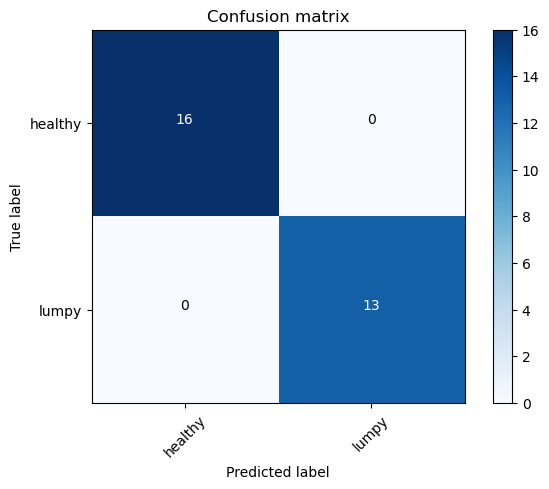

In [21]:
plot_confusion_matrix(confusion_matrix, ['healthy', 'lumpy'])

Normalized confusion matrix


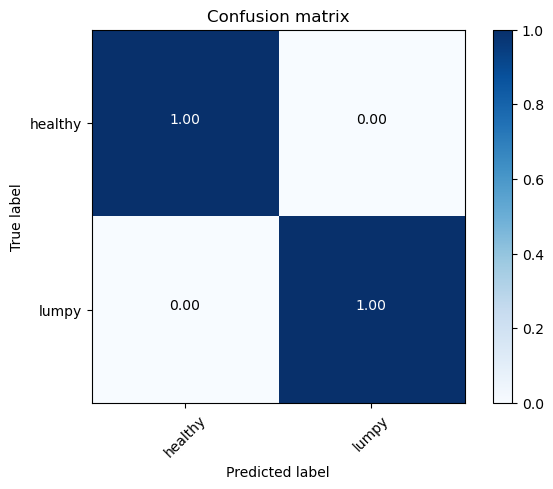

In [22]:
plot_confusion_matrix(confusion_matrix, 
                      ['healthy', 'lumpy'],
                     normalize=True)


In [23]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [24]:
def test_single_image(path):
    Fassions = ['healthy', 'lumpy']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)

    for idx, fassion, x in zip(range(0,6), Fassions , preds[0]):
        
        print("ID: {}, Label: {} {}%".format(idx, fassion, round(x*100,2) ))
       
    print('Final Decision:')
    time.sleep(.5)
    if (round(x*100,2)>200):
        print("Not in the list")
        
    else:
        for x in range(3):
            print('.'*(x+1))
            time.sleep(.2)
        class_predicted = (model.predict(bt_prediction)>0.5).astype("int32")
        class_dictionary = generator_top.class_indices  
        inv_map = {v: k for k, v in class_dictionary.items()}  
        print("ID: {}, Label: {}".format(class_predicted[0], inv_map[np.argmax(class_predicted[0])]))  
        return load_img(path)


In [29]:
path = 'C:\\Users\\HP\\OneDrive\\Desktop\\pro_dataset\\demo images\\10.jpg'#add test path for test images

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 49ms/step
ID: 0, Label: healthy 0.01%
ID: 1, Label: lumpy 99.99%
Final Decision:
.
..
...
1/1 [==============================] - 0s 52ms/step
ID: [0 1], Label: lumpy


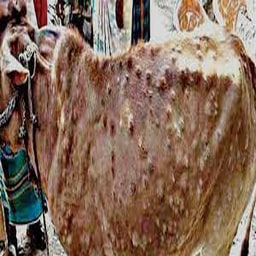

In [30]:
test_single_image(path)